# The Distance of Slavery 
## Andrea Hayes
### July 31, 2024

# Introduction 
Slavery is a dark part in the history of America, specifically in the south. The southern states used slave labor to strengthen their economy. They benefited so much that by the early 1860’s they would have been the 4th largest economy in the world[2]. This type of impact on their economy made it quite obvious that they were not going to give it up willingly. Like many things in politics the change to abolish slavery took decades and came in many forms. This meant that the men of the south knew that change would be coming long before it actually did. How they approached slavery would depend on where they were located and how the politics changed from decade to decade. By the end of the 1850’s it was clear that the decades long debate was coming to a head. 

New Orleans had a unique slave trade in that slaves were sold all throughout the city. It was common in other cities that slaves were sold only in a single market or known locations. In New Orleans though slaves could be sold about anywhere you could think of. The Historic New Orleans Collection lists the numerous places, “Auction blocks in the sumptuous rotunda of the St. Louis Hotel, private residences, public parks, decks of ships moored along the Mississippi, high-walled slave pens, and commercial complexes such as Banks Arcade all served as sites for the buying and selling of human beings”.[3]  This made New Orleans a vital market for the slave trade.   

In their paper that used the same dataset, authors Calomiris and Pritchett found the price of slaves in 1861 had dropped by one third since 1860. They go on to explain that by this time slave owners saw the writing on the wall that they were not going to get compensated after emancipation.[1] The political climate was changing with the looming war over slavery and what rights the states had. Their research is interesting in how they show the commodity that was slavery changed as the onset of the war began. 

As we live through historical events it seems obvious or sometimes not so obvious about the decisions we make based on how we think the future will be. We don't always have the foresight for these decisions or there are too many factors at play for us to be able to see how it will all play out. The dataset with slavery from 1856 - 1861 made me wonder if men of the time changed their decisions based on the political climate. If they were in the south and assumed the south would succeed then they would see no need to change how they did business. If they were in the north it was becoming tricker to participate in the slave trade and they needed to travel farther. 

 ## Research Questions
  Did the geographic distribution of buyers or sellers of slaves change as the civil war approached?
  
  How far did the average person travel to sell a slave in New Orleans? 


# Methods

 The dataset from CORGIS has the records of 9,599 slaves sold in New Orleans from 1856 - 1861. It has a wide variety of information from the buyer, seller and slave on each sale. It includes the buyers and sellers names and where they are from. For the slaves it includes their gender, age, amount sold for, and other financial information. To get the distance from New Orleans to the various cities I made my own dataset. I exported the seller's origins into the sheet and used a script to calculate the distances.   

Since my questions focus on where the buyers and sellers are from and the distance they traveled I focused on the buyer origin and seller origin as well as the year of the transaction from CORGIS dataset. The CORGIS dataset gives not only the year, but the full transaction date. Since I am only interested in the year I converted it to datetime so that I could extract the year. Before doing this I needed to change the day format because some had a '.' instead of the day. I replaced the '.' with NaN values. I was then able to extract just the year from the transaction date.

The buyer and sellers origins were the same in the data they contained which was a city and state. I used the following methods to clean both columns of data. There were unknown cities and since this information was not necessary I removed it from the dataset. Next I noticed that sometimes a ',' was put after the whitespace instead of before and that 'New Orleans' was sometimes simplified to 'Orleans'. I applied the replace function to account for both of these occurrences. At this point the data was ready to be analyzed and I did so with the group function. I grouped the cities by year and then extracted the top 5 cities. 

To get the distances from New Orleans to the seller's origins I exported the sellers origins into a google sheet. I had a previous script to calculate the driving distances from a personal project. Once I removed the error cells from the csv I merged the distance data with the slavery data. This allowed me to find the average distance traveled by sellers per year.  

# Results




In [237]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re 

#Retrieve html code from CORGIS
url = "https://corgis-edu.github.io/corgis/csv/"
response = requests.get(url)
html_content = response.text

#Parse the html and create a list
soup = BeautifulSoup(html_content, 'html.parser')
h3_tags = soup.find_all('h3')

#Make list of all dataset names that CORGIS has
corgis_list = [tag.get_text() for tag in h3_tags]


#Takes in number of dataset and returns a Pandas dataframe
def pdcorgis(dataset_name):

    #Convert to lowercase and add _ to needed datasets
    dataset_name_lower = dataset_name.lower().replace(' ', '_')
    # print(dataset_name_lower)
    
    #Get HTML from CORGIS page
    dataset_url = f"https://corgis-edu.github.io/corgis/csv/{dataset_name_lower}/"
    dataset_response = requests.get(dataset_url)
    dataset_html_content = dataset_response.text

    #Parse the HTML and find links
    dataset_soup = BeautifulSoup(dataset_html_content, 'html.parser')
    links = dataset_soup.find_all('a')

    #Find download link
    download_link = None
    for link in links:
        if link.has_attr('download'):
            download_link = link['href']
            break

    if download_link is None:
        raise ValueError("Download link for {dataset_name} not found")
    
    #Get link to use for csv
    csv_url = f"https://corgis-edu.github.io/corgis/csv/{dataset_name_lower}/{download_link}"
    # print(csv_url)

    #Read the csv file into Pandas
    corgis_dataframe = pd.read_csv(csv_url)

    return corgis_dataframe


In [238]:
slavery_data = pdcorgis(corgis_list[47]) 

# print(slavery_data.head()) 
# print(slavery_data)

# Remove unknown values from the buyer and seller city
slavery_data = slavery_data[slavery_data['Buyer.Origin'] != 'Unknown, Unknown'] 
slavery_data = slavery_data[(slavery_data['Seller.Origin'] != 'Unknown, Unknown') & (slavery_data['Seller.Origin'] != 'Unknown, LA')]
# print(slavery_data)

# Replace dots in date with with NaN
slavery_data['Transaction.Date'].replace('.', np.nan, inplace=True)

# Convert the 'Transaction.Date' column to datetime, errors='coerce' will convert invalid dates to NaT
slavery_data['Transaction.Date'] = pd.to_datetime(slavery_data['Transaction.Date'], format='%m/%d/%Y', errors='coerce')

# Retrieve the year from the transaction date
year = slavery_data['Year'] = slavery_data['Transaction.Date'].dt.year
# print(year)

#Normalize the Cities by striping whitespace and replacing , with whitespace, put Orleans and New Orleans together
slavery_data['Buyer.Origin'] = (slavery_data['Buyer.Origin'].str
    .replace(r"^Orleans\,\sLA$", "New Orleans, LA", regex=True)
    .replace(r"(\w+)\s*,\s*(\w{2})", r"\1, \2", regex=True)
)

slavery_data['Seller.Origin'] = (slavery_data['Seller.Origin'].str
    .replace(r"^Orleans\,\sLA$", "New Orleans, LA", regex=True)
    .replace(r"(\w+)\s*,\s*(\w{2})", r"\1, \2", regex=True)
)

years_wanted = [1856, 1857, 1858, 1859, 1860, 1861]
filtered_years = slavery_data[slavery_data['Year'].isin(years_wanted)]
# print("Filtered_years" , filtered_years)

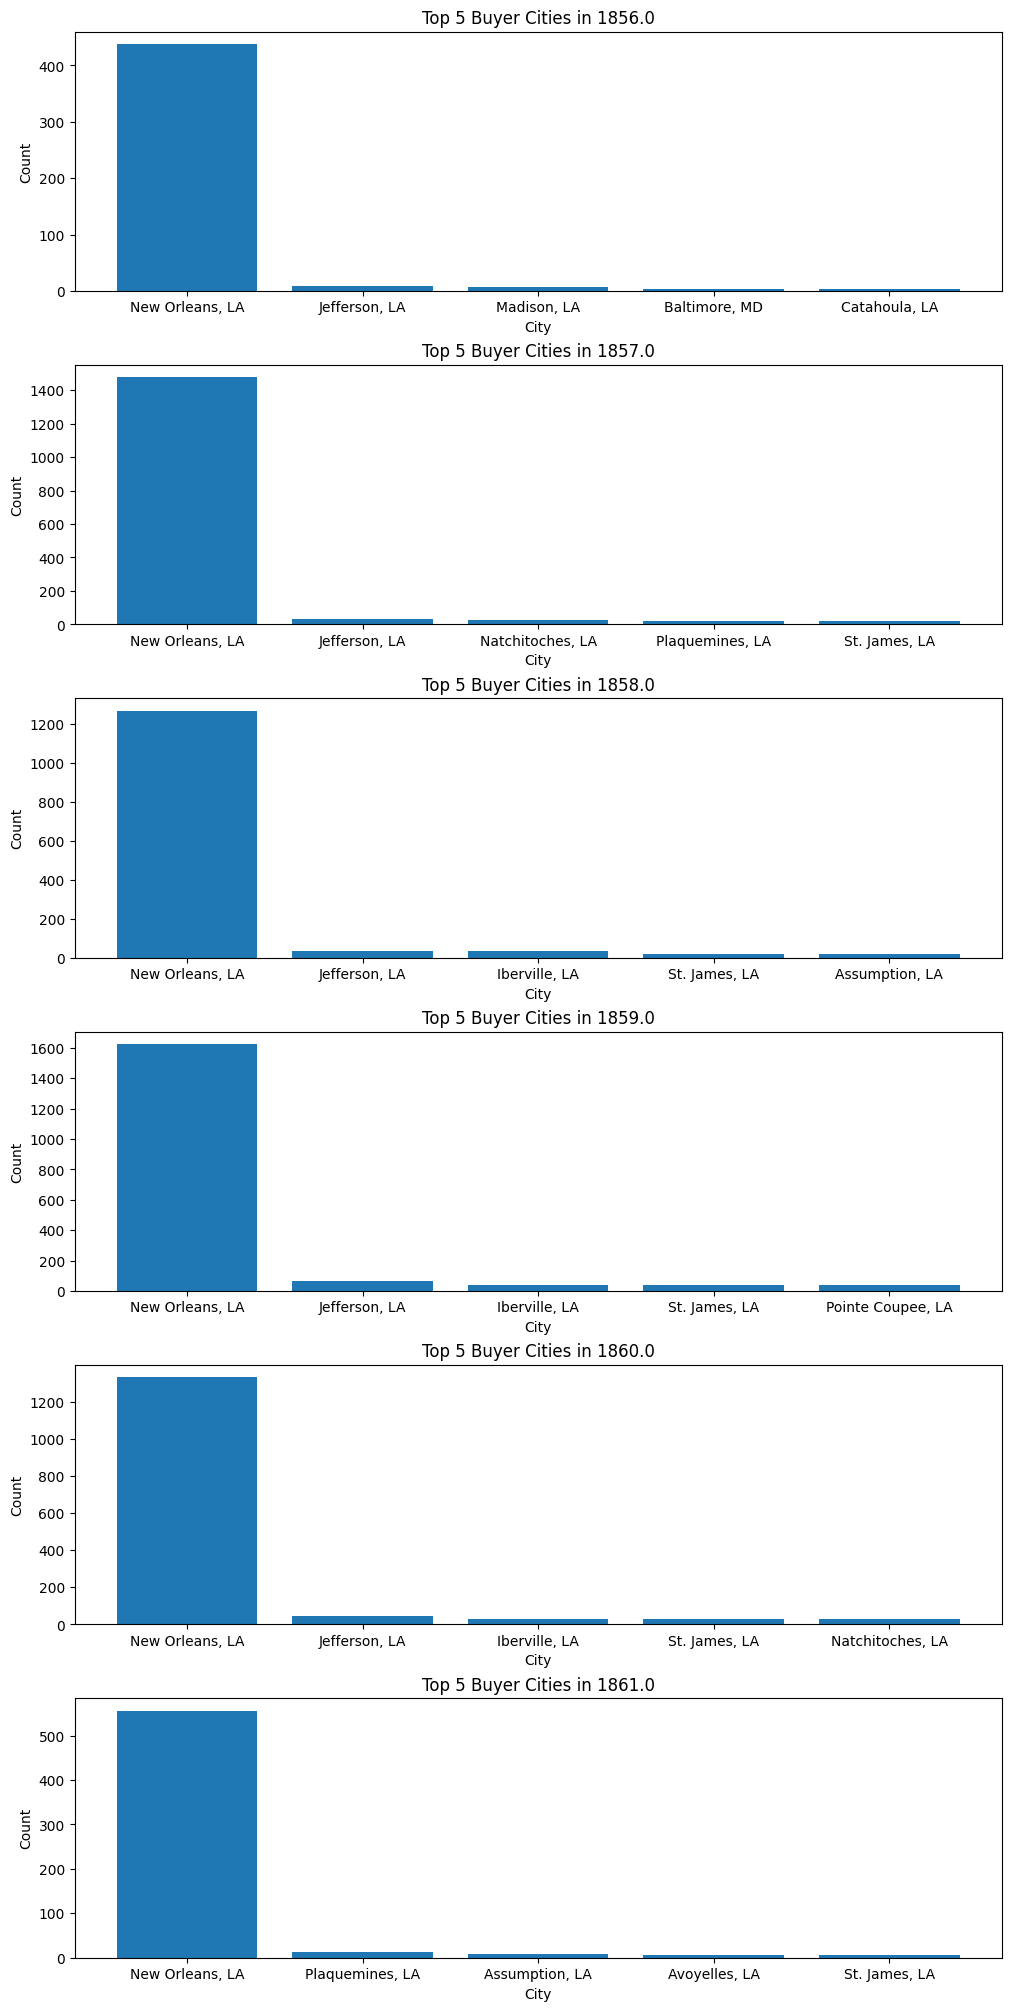

In [ ]:
#Top 5 Cities Buyer's were from for 1856 - 1861

# Group by year and get top 5 cities for each year
top_buyer_cities_per_year = filtered_years.groupby(['Year', 'Buyer.Origin']).size().groupby(level=0).nlargest(5).reset_index(level=0, drop=True).reset_index(name='Count')

# Plot
years = filtered_years['Year'].unique()
# print(years)

fig, axes = plt.subplots(nrows=len(years), ncols=1, figsize=(10, 20), constrained_layout=True)

for i, year in enumerate(years):
    top_cities = top_buyer_cities_per_year[top_buyer_cities_per_year['Year'] == year]
    axes[i].bar(top_cities['Buyer.Origin'], top_cities['Count'])
    axes[i].set_title(f'Top 5 Buyer Cities in {year}')
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel('City')

plt.show()

# Analysis for Buyer Origins
These six bar graphs tell us that the people buying slaves were local. They also didn't go far with the vast majority of slaves staying in New Orleans. Aside from one outlier in 1856 from Baltimore they are all from Louisiana. This tells us that slaves purchased in New Orleans stayed local. These graphs also contain a count for the number of slaves sold each year. 1856 was the lowest year with around 500 total slaves sold. While 1857 -1860 saw between 1,200 and 1,600 slaves sold each year. When looking at the difference between 1860 and 1861 there is a drastic decrease from more than 1,200 in 1860 to just over 500 in 1861. The start of the civil war clearly had and impact on the slave trade.  

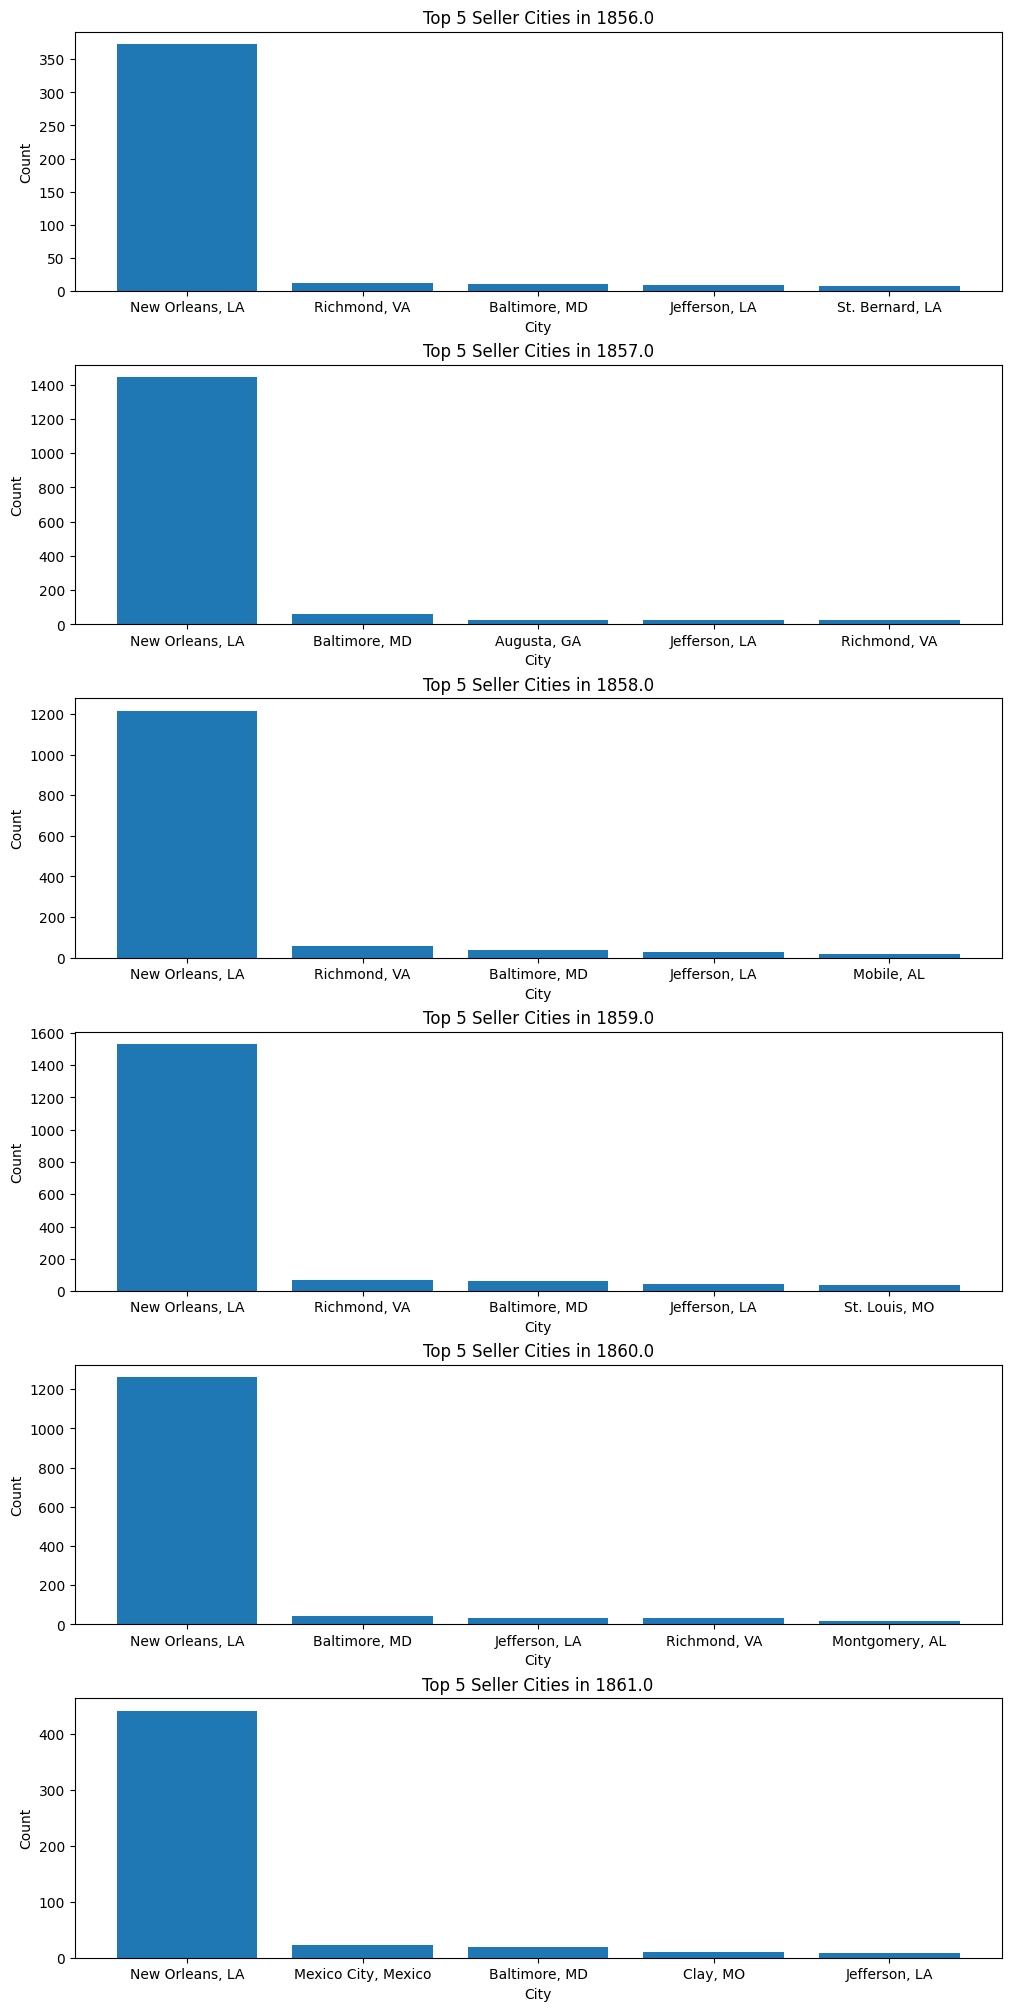

In [239]:
#Top 5 Cities Seller's were from 1856 - 1861 
top_seller_cities_per_year = filtered_years.groupby(['Year', 'Seller.Origin']).size().groupby(level=0).nlargest(5).reset_index(level=0, drop=True).reset_index(name='Count')

fig, axes = plt.subplots(nrows=len(years), ncols=1, figsize=(10, 20), constrained_layout=True)

for i, year in enumerate(years):
    top_cities = top_seller_cities_per_year[top_seller_cities_per_year['Year'] == year]
    axes[i].bar(top_cities['Seller.Origin'], top_cities['Count'])
    axes[i].set_title(f'Top 5 Seller Cities in {year}')
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel('City')

plt.show()

# Analysis for Seller Origins

The bar graphs for where the sellers come from gives a much more interesting look at the slave trade. Most of the sellers were still local being from New Orleans. But the next 4 cities for most of the years come from a variety of different places, many quite far away. Cities like Baltimore, MD and Richmond, VA show up frequently even before the civil war ramped up. The outlier on these graphs is Mexico City in 1861.  Since they information was pulled from the same dataset it makes sense that the number of slaves sold is similar to the buyer origins graphs.  

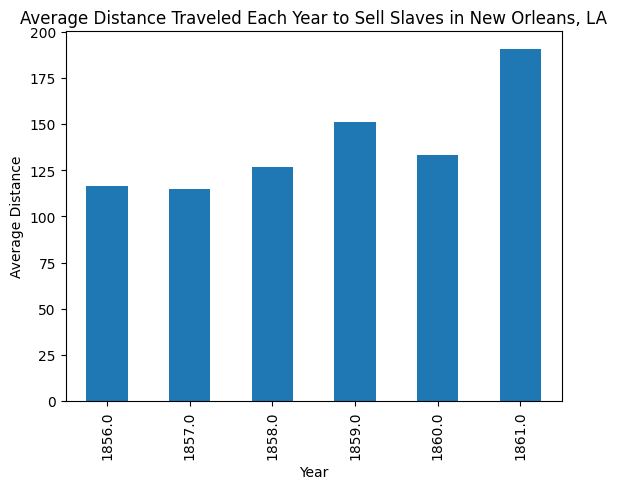

In [236]:
#Distance from New Orleans

distance_data = pd.read_csv("Distances_from_New_Orleans.csv" )
distance_data = distance_data[distance_data['Distance'] != "#ERROR!"]
# print(distance_data)

# print(slavery_data.shape[0])
slavery_data_with_distances = pd.merge(slavery_data, distance_data, left_on='Seller.Origin', right_on='City', how='left')
# print(slavery_data_with_distances.shape[0])
slavery_data_with_distances = slavery_data_with_distances.dropna(subset=['Distance'])
slavery_data_with_distances['Distance'] = slavery_data_with_distances['Distance'].astype(int)
# print(slavery_data_with_distances.shape[0])

slavery_data_with_distances = slavery_data_with_distances[slavery_data_with_distances['Year'].isin(years)]

#
# Bar char by year
#

avg_distance_by_year = (slavery_data_with_distances
    .groupby('Year')
    ['Distance'].mean()
    .reset_index()
)

avg_distance_by_year.plot(kind='bar', x='Year', y='Distance', legend=False)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Average Distance')
plt.title('Average Distance Traveled Each Year to Sell Slaves in New Orleans, LA')

# Show the plot
plt.show()




# Analysis of Distance Traveled    

When looking at the average distance a slave traveled to be sold most of them did not travel far. This tracks with the previous visualizations that most were bought and sold locally. While the slaves from Baltimore, Richmond, and Mexico traveled around 1,000 miles. There is a spike in 1861 that shows as the war neared people were traveling farther to sell their slaves. This aligns with the fact that tensions were getting strong in the North. 

# Discussion
* Discussion (what does your analysis show, what is the big picture, and how are
these findings useful?) 
These findings show that more people did travel farther from northern states to sell slaves in 1861 than in the 5 years before. It was not a substantial amount, but the average distance did increase. For the most part slaves were bought and sold locally within New Orleans. This makes sense as traveling in that time period was strenuous. After excluding New Orleans it is seen that there were about 10 % of slaves sold in New Orleans came from the North. This did not change closer to 1861. The number of slaves changed, but not where they were coming from. 
The slaves that were sold from Mexico raises more questions than it answers. Mexico had abolished slavery in 1937 and was know as a refuge for slaves from Texas[4]. Were there some bad actors that rounded up these slaves in Mexico and returned them to the United States? 
The information from this dataset is only taken from New Orleans which is a city in the deep south. To get a broader answer to these questions more cities would need to be researched. If slave holders in northern states were attempting to off load their slaves then there are many more confederate cities closer than New Orleans. Since the buyers were mostly local it is possible that it was worth the extra miles to bring the slaves that far. 
The number of slaves sold decreased as the war approaced and the distance they travelled became greater. It appears it was common practice to bring slaves from northern states and have them sold locally. The cities that the slaves came from did not have a drastic change meaning that the slave trade slowed overall, but the routes did not. 

# References 

1. Calomiris, Charles W., and Jonathan Pritchett. 2016. "Betting on Secession: Quantifying Political Events Surrounding Slavery and the Civil War." American Economic Review, 106 (1): 1–23. DOI: 10.1257/aer.20131483

2. Timmons, Greg. "How Slavery Became the Economic Engine of the South." HISTORY, A&E Television Networks, 2 Apr. 2024, https://www.history.com/news/slavery-profitable-southern-economy. Accessed 27 July 2024.

3. "New Orleans, Slave Market of the South." The Historic New Orleans Collection, accessed July 27, 2024. https://www.hnoc.org/virtual/purchased-lives/new-orleans-slave-market-south.